<a href="https://colab.research.google.com/github/ymz1529/p300test/blob/main/notebook-scripts/P300speller%EF%BC%88%E5%BD%BB%E5%BA%95%E8%B7%91%E9%80%9A1%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#P300 SPELLER SETTINGS

TRAINED MODEL SELECTION:                                                                                                   
- **CNN1**  :  trained on the whole trainset without balancing;                                                               
- **CNN2a** :  uses 8 channels EEG signals [FZ, CZ, PZ, P3, P4, PO7, PO8, and OZ];                                            
- **CNN2b** :  same as CNN2a but channels are selected by looking at the filters' weights in layer 1 of CNN1;
- **CNN2c** :  same as CNN2a but channels are selected by topological area;              
- **CNN3**  :  same as CNN1 but uses only 1 filter in layer 1 instead of 10;                                                       
- **MCNN1** :  multiclassifier of 5 CNN1 each trained over 5 different balanced trainsets;                                    
- **MCNN2** :  multiclassifier of 5 CNN1 each trained over consecutive datasets obtained by splitting the trainset into 5;    
- **MCNN3** :  multiclassifier of 3 CNN1 trained without trainset balancing and with randomized weights inizialization;       
                                                                                                                             
SUBJECT'S DATA SELECTION:                                                                                                  
- **A**: Signal samples: 7794, EEG channels: 64, Testset letters: 100;                                                        
- **B**: Signal samples: 7794, EEG channels: 64, Testset letters: 100;                                                          
                                                                                                                                                   
ELECTRODE SUBSET SELECTION (CNN2c only, other models use predefined channels):                                                                                                
- **F**: Frontal lobe electrodes;                                                                                
- **C**: Central lobe electrodes;                                                                                               
- **P**: Parietal lobe electrodes;                                                                                             
- **O**: Occipital lobe electrodes;                                                                                            
- **LT**: Left temporal lobe electrodes;                                                                                       
- **RT**: Right temporal lobe electrodes;  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from scipy.io import loadmat
from scipy import signal
from google.colab import drive
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# Install mne library for topoplot
!pip install mne
import mne

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

####################### SETTINGS ########################
# Set this variable with the desidered model's name     #
MODEL_SELECTED = "CNN1"                                #
#                                                       #
# Set this variable with the desidered subject's letter #
SUBJECT_SELECTED = "B"                                  #
#                                                       #
# Set this variable with the desired electrode subset   #
ELECTRODE_SELECTED = "O" # CNN2c only                   #
#########################################################

model_names = ["CNN1", "CNN2a", "CNN2b", "CNN2c", "CNN3", "MCNN1", "MCNN2", "MCNN3"]
subject_names = ["A", "B"]
electrode_names = ["F", "C", "P", "O", "LT", "RT"]

# Check for errors in the settings
if MODEL_SELECTED not in model_names:
    raise ValueError("MODEL_SELECTED value {} is invalid.\nPlease enter one of the following parameters {}".format(MODEL_SELECTED, model_names))
elif SUBJECT_SELECTED not in subject_names:
    raise ValueError("SUBJECT_SELECTED value {} is invalid.\nPlease enter one of the following parameters {}".format(SUBJECT_SELECTED, subject_names))
elif MODEL_SELECTED == "CNN2c" and ELECTRODE_SELECTED not in electrode_names:
    raise ValueError("ELECTRODE_SELECTED value {} is invalid\nPlease enter one of the following parameters {}".format(ELECTRODE_SELECTED, electrodes_names))

# Google drive data paths
MODEL_LOCATIONS_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Trained_models/' + MODEL_SELECTED + '/' + SUBJECT_SELECTED
SUBJECT_TRAIN_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/Subject_' + SUBJECT_SELECTED + '_Train.mat'
SUBJECT_TEST_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/Subject_' + SUBJECT_SELECTED + '_Test.mat'
CHANNEL_LOCATIONS_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/channels.csv'
CHANNEL_COORD = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/coordinates.csv'

# Channel selection
if MODEL_SELECTED == "CNN2a":
    CHANNELS = [10, 33, 48, 50, 52, 55, 59, 61]

elif MODEL_SELECTED == "CNN2b":
    if SUBJECT_SELECTED == "A":
        CHANNELS = [10, 14, 17, 50, 55, 57, 59, 60]
    elif SUBJECT_SELECTED == "B":
        CHANNELS = [17, 50, 55, 56, 57, 58, 59, 60]

elif MODEL_SELECTED == "CNN2c":
    if ELECTRODE_SELECTED == "F":
        CHANNELS = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
    elif ELECTRODE_SELECTED == "C":
        CHANNELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    elif ELECTRODE_SELECTED == "P":
        CHANNELS = [15, 16, 17, 18, 19, 48, 49, 50, 51, 52]
    elif ELECTRODE_SELECTED == "O":
        CHANNELS = [55, 56, 57, 58, 59, 60, 61, 62]
    elif ELECTRODE_SELECTED == "LT":
        CHANNELS = [14, 38, 40, 44, 46, 47]
    elif ELECTRODE_SELECTED == "RT":
        CHANNELS = [20, 39, 41, 45, 53, 54]

else:
    CHANNELS = [i for i in range(64)]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.1 MB/s eta 0:00:00
Mounted at /content/drive


# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, N_CHANNELS)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [ ]:
# Test data loading
if not os.path.exists(SUBJECT_TEST_FILE_PATH):
    print("Missing file: {}".format(SUBJECT_TEST_FILE_PATH))
else:
    # Load the required data
    data_test = loadmat(SUBJECT_TEST_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    signals_test = signals_test[:, :, CHANNELS]

    flashing_test = data_test['Flashing']
    word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS_TEST = len(word_test[0])
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    print("Spelled word:       %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100
Spelled word:       MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


In [ ]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

for trial in range(TRIALS_TEST):
    counter=0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [ ]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [ ]:
# Down-sampling of the signals from 240Hz to 120Hz
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]
stimulus_code_test = stimulus_code_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [ ]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 78, 64)


In [ ]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

In [ ]:
# Randomizing function for bias and weights of the network
import tensorflow as tf
def cecotti_normal(shape, dtype = None, partition_info = None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    return tf.random.normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

In [ ]:
# Custom tanh activation function
import tensorflow as tf

def scaled_tanh(z):
    return 1.7159 * tf.math.tanh((2.0 / 3.0) * z)

In [ ]:
# Build the model
def CNN_model(channels=64, filt=10):
    model = Sequential([
        Conv1D(
            filters = filt,
            kernel_size = 1,
            padding = "same",
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
            input_shape = (78, channels)
        ),
        Conv1D(
            filters = 50,
            kernel_size = 13,
            padding = "valid",
            strides = 11,
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

In [ ]:
# Multiclassifier prediction function
def majorityPrediction(models, inputs):
    pred = []
    # Get models predictions
    for model in models:
        pred.append(model.predict(inputs))
    pred = np.array(pred)
    return pred.mean(axis=0).flatten()

In [ ]:
# Model settings
if MODEL_SELECTED in ["CNN1", "MCNN1", "MCNN2", "MCNN3"]:
    channels = 64
    filters = 10
elif MODEL_SELECTED == "CNN2a":
    channels = 8
    filters = 10
elif MODEL_SELECTED == "CNN2b":
    channels = 8
    filters = 10
elif MODEL_SELECTED == "CNN2c":
    channels = N_CHANNELS
    filters = 10
elif MODEL_SELECTED == "CNN3":
    channels = 64
    filters = 1

# CNN1, CNN2a, CNN2b, CNN2c, CNN3 are single classifiers
if MODEL_SELECTED in ["CNN1", "CNN2a", "CNN2b", "CNN2c", "CNN3"]:
    N_NETWORKS = 1
    # Model definition
    model = CNN_model(channels, filters)
    # Load model weights from h5 file
    if MODEL_SELECTED == "CNN2c":
        model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model" + ELECTRODE_SELECTED + ".h5")
    else:
        model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model.h5")
    # Compile model model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    # Create dictionary to store models
    model_dict = {1:model}

# MCNN3 is composed by 3 CNN1 models
elif MODEL_SELECTED in ["MCNN3"]:
    N_NETWORKS = 3
    # Model definition
    model1 = CNN_model(channels, filters)
    model2 = CNN_model(channels, filters)
    model3 = CNN_model(channels, filters)
    # Load model weights from h5 file
    model1.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model1.h5")
    model2.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model2.h5")
    model3.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model3.h5")
    # Compile model model
    model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    model2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    model3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    # Create dictionary to store models
    model_dict = {1:model1, 2:model2, 3:model3}

# MCNN1 and MCNN2 are composed by 5 CNN1 models
elif MODEL_SELECTED in ["MCNN1", "MCNN2"]:
    N_NETWORKS = 5
    # Model definition
    model1 = CNN_model(channels, filters)
    model2 = CNN_model(channels, filters)
    model3 = CNN_model(channels, filters)
    model4 = CNN_model(channels, filters)
    model5 = CNN_model(channels, filters)
    # Load model weights from h5 file
    model1.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model1.h5")
    model2.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model2.h5")
    model3.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model3.h5")
    model4.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model4.h5")
    model5.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model5.h5")
    # Compile model model
    model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    model2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    model3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    model4.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    model5.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    # Create dictionary to store models
    model_dict = {1:model1, 2:model2, 3:model3, 4:model4, 5:model5}

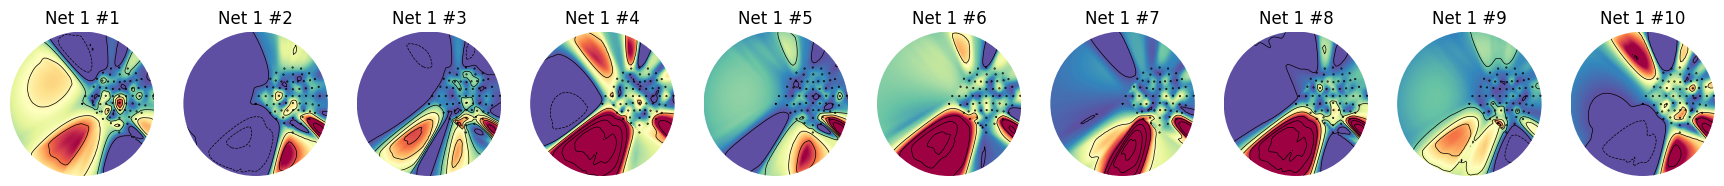

In [ ]:

# Load topoplot coordinates
if not os.path.exists(CHANNEL_COORD):
    print("Missing file: {}".format(CHANNEL_COORD))
else:
    xycoord = []
    # Read file content
    with open(CHANNEL_COORD, "r") as f:
        file_content = f.read()
        # Loop over all rows
        for row in file_content.split("\n"):
            # Skip missing rows
            if row == '':
                continue
            xycoord.append(row)

# Create a list with x, y coordinates of each electrode (convert to float)
coord = []
for x in xycoord:
    coord.append([float(i) for i in x.split(',')])  # Ensure to convert to float
coord = np.array(coord)

# Flip y axis to plot the electrodes correctly
for i in range(len(coord)):
    coord[i][1] = 681 - int(coord[i][1])

# Create a list of weights for all filters
nf = []
for net in range(N_NETWORKS):
    for filt in range(filters):
        # Extract the weights of the filters (ensure to convert to float)
        nf.append(abs(np.array(model_dict[net+1].get_weights()[0])[0, :, filt]))
nf = np.array(nf, dtype=float)

# Add -1 to missing channel values
tmp_full = []
for net in range(N_NETWORKS):
    for filt in range(filters):
        tmp = np.full(64, 0, dtype=float)
        for chan in range(channels):
            tmp[CHANNELS[chan]] = nf[filt + net * filters][chan]
        tmp_full.append(tmp)
nf = np.array(tmp_full, dtype=float)

# Plot topoplot of the filters in the first convolutional layer
fig = plt.figure(figsize=(22, 8))
for tot in range(N_NETWORKS * filters):
    ax = fig.add_subplot(N_NETWORKS, filters, tot + 1)
    ax.set_title("Net {} #{}".format((tot // 10) + 1, (tot) % 10 + 1))
    # Ensure nf[tot] is a 1D array of length equal to the number of channels
    mne.viz.plot_topomap(nf[tot], coord, cmap='Spectral_r', axes=ax, show=False)

plt.show()

In [ ]:
# Accuracy over the testing set 评估模型在测试集上的准确率，并打印出结果。以下是代码的详细中文注释
if MODEL_SELECTED in ["CNN1", "CNN2a", "CNN2b", "CNN2c", "CNN3"]:
    predictions = model.predict(test_features).flatten()
elif MODEL_SELECTED in ["MCNN1", "MCNN2"]:
    predictions = majorityPrediction(models=[model1, model2, model3, model4, model5], inputs=test_features)
elif MODEL_SELECTED in ["MCNN3"]:
    predictions = majorityPrediction(models=[model1, model2, model3], inputs=test_features)

# Model evaluation
score = 0
for i in range(len(test_labels)):
    if test_labels[i] == predictions[i].round():
        score += 1
score /= len(predictions)

if MODEL_SELECTED == "CNN2c":
    print("Model {} on subset {}: accuracy on test set: {}%".format(MODEL_SELECTED, ELECTRODE_SELECTED,round(score*100, 4)))
else:
    print("Model {}: accuracy on test set: {}%".format(MODEL_SELECTED, round(score*100, 4)))

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model CNN1: accuracy on test set: 82.55%


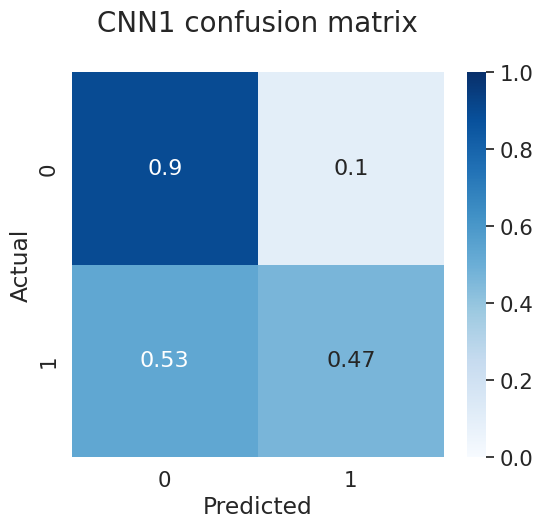

In [ ]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data = confusion_matrix(y_true=test_labels, y_pred=predictions.round(), sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("{} confusion matrix\n".format(MODEL_SELECTED), fontsize=20)
plt.show()

In [ ]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

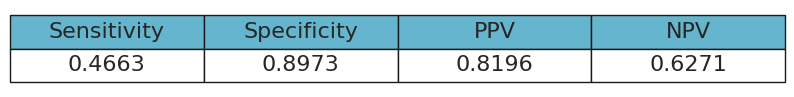

In [ ]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())],
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()

#P300 speller
1.   Get the predictions from the selected model;
2.   Sort the predictions following the enumeration of columns and rows in the char matrix;
3.   Calculate mean predictions in **N** epochs;
4.   Process one epoch of predictions such that it contains exactly two **1** and ten **0**:
> * Round the highest element between **1<=x<=6** to **1** (detected column);
> * Round the highest element between **7<=x<=12** to **1** (detected row);
> * Round everything else to **0**;
5.   Get letter corresponding to the intersection of column and row in the char matrix;
6.   Compare the predictions with the labels provided;

(optional)
7.   Construct a dictionary to keep track of any char occurrences during epochs ;
8.   Use the dictionary to decide which is the most probable letter in case of a tie;


P300拼字

从选定的模型中获得预测结果；

对char矩阵中列和行枚举之后的预测进行排序；

计算N个周期的平均预测；

处理一个时期的预测，使它恰好包含两个1和十个0：

舍入1<=x<=6到1之间的最高元素（检测到的列）；

将7<=x<=12之间的最高元素四舍五入到1（检测行）；

其余四舍五入为0；

得到字符矩阵中列与行交点对应的字母；

将预测与提供的标签进行比较；

(可选)



构造一个字典来跟踪在epoch期间出现的任何字符；

在平局的情况下，用字典来决定哪个是最可能的字母；













In [ ]:
# If intersection is valid (row-col) and returns char, otherwise returns none
# 用于检查给定的行和列索引是否表示一个有效的交点，并返回对应的字符。如果给定的索引不构成一个有效的交点（即，它们不表示一个唯一的字符），则函数返回 None
def check_letter(x, y):
    # Check if x and y are two columns or two rows
    if ((x >= 1 and x <= 6) and (y >= 1 and y <= 6)) or ((x >= 7 and x <= 12) and (y >= 7 and y <= 12)):
        return None
    else:
        list1 = list_matrix[x - 1]
        list2 = list_matrix[y - 1]
        for c in list1:
            # If char is also in list2, it is the intesection of col and row
            if c in list2:
                return c

In [ ]:
# Returns the intersection for all permutations of columns and rows
def check_intersect(list_colrow):
    intersect = []
    for x in range(len(list_colrow)-1):
        for y in range(x+1, len(list_colrow)):
            tmp = check_letter(list_colrow[x], list_colrow[y])
            if tmp:
                intersect.append(tmp)
    return intersect

In [ ]:
# Keeps track of multiple occurrences during epochs
#  dict_predictions 的函数，它用于在多个epoch中跟踪每个字符的出现次数，并计算每个字符的累计权重
def dict_predictions(predictions, stimulus, n_epoch, A=1, B=0):
    # A: Certainty decreses with number of possible guesses
    # B: Certainty increases with number of epochs processed
    dict_char = {}
    for epoch in range(1, n_epoch + 1):
        list_flash = []
        for index in range(12):
            # Obtain single epoch of data
            pred = predictions[12*(epoch-1):12*epoch]
            stim = stimulus[12*(epoch-1):12*epoch]
            # Sort pred following 1->12 col/row ordering
            sorted_pred = sort_predictions(pred, stim)
            # Round predictions to contain only 1 and 0
            round_pred = round_argmax(sorted_pred)
            # Append cols and rows number where there's a flash
            if round_pred[index] == 1:
                list_flash.append(index+1)
        # Get all intersections and create dict with all occurrences
        intersect = check_intersect(list_flash)
        for inter in intersect:
            if inter not in dict_char.keys():
                dict_char[inter] = A*(1/len(intersect)) + B*((epoch+1)/n_epoch)
            else:
                dict_char[inter] += A*(1/len(intersect)) + B*((epoch+1)/n_epoch)
    return dict_char

In [ ]:
# Get list of all char predictions
# # 用于从单个epoch的预测结果中提取可能的字符，这些字符是列和行预测结果的交点，即P300拼写器中被试可能选择的字符
def char_predictions(sorted_pred):
    # Precodition1: sorted_pred sorteded by col/row enumeration
    # Precodition2: takes only 1 epoch at the time
    list_flash = []
    for index in range(12):
        if sorted_pred[index] == 1:
            list_flash.append(index + 1)
    intersect = check_intersect(list_flash)
    return intersect

In [ ]:
# Rounds and adjusts predictions to contain two 1 and ten 0
# 用于从每个epoch的预测结果中识别出最可能的列和行响应

def round_argmax(sorted_pred):
    # Precodition1: sorted_pred sorteded by col/row enumeration
    # Precodition2: takes only 1 epoch at the time
    adjust_cols = [0 for i in range(6)]
    adjust_rows = [0 for i in range(6)]
    sortcols = list(sorted_pred[:6])
    sortrows = list(sorted_pred[6:])
    sortcols.sort()
    sortrows.sort()
    for i in range(6):
        if sorted_pred[i] == sortcols[-1]:
            adjust_cols[i] = 1
    for i in range(6):
        if sorted_pred[6+i] == sortrows[-1]:
            adjust_rows[i] = 1
    return adjust_cols + adjust_rows

In [ ]:
# Sort pred following 1->12 col/row ordering
# 用于将预测结果按照特定的顺序（由刺激信号决定的列/行编号）进行排序，以便后续的处理和分析
def sort_predictions(predictions, stimulus):
    # Precondition: takes only 1 epoch at the time
    sorted_pred = [0 for i in range(12)]
    for index in range(12):
        sorted_pred[int(stimulus[index]) - 1] = predictions[index]
    return sorted_pred

In [ ]:
# Estimate the expected values for each prediction in n epochs
# 用于从多个epoch的预测结果中估计每个位置的平均预测值，这有助于提高预测的准确性和可靠性。通过平均多个epoch的结果，可以减少随机波动的影响，得到更稳定的预测结果
def mean_predictions(predictions, stimulus, n_epoch):
    epoch_matrix = []
    for epoch in range(1, n_epoch + 1):
        # Obtain single epoch of data
        pred = predictions[12*(epoch-1):12*epoch]
        stim = stimulus[12*(epoch-1):12*epoch]
        # Sort pred following 1->12 col/row ordering
        sorted_pred = sort_predictions(pred, stim)
        # Append sorted epoch of pred into matrix
        epoch_matrix.append(sorted_pred)
    # Mean over n_epochs to improve estimation of prediction
    return np.array(epoch_matrix).mean(axis=0)


In [ ]:
# In case of ties we look at the occurrences to find the most probable
# 用于在多个字母预测结果相同的情况下，根据它们在多个epoch中出现的次数来选择最可能的字母
def break_ties(word_pred, dict_pred):
    max_occ = 0
    max_pred = None
    letters = []
    results = []
    for letter in word_pred:
        if letter in dict_pred.keys():
            letters.append(letter)
            if dict_pred[letter] > max_occ:
                max_occ = dict_pred[letter]
    # We found a least 1 letter in the dict
    if max_occ > 0:
        for letter in letters:
            if dict_pred[letter] == max_occ:
                results.append(letter)
    # If the tie still holds, return random element from results
    if results:
        return random.choice(results)
    else:
        return random.choice(word_pred)

In [ ]:
#打印模型和受试者信息。
#初始化存储每个epoch拼写预测结果的字典和准确率得分的列表。
#遍历每个epoch，对于每个epoch，遍历每个字符，使用mean_predictions函数对预测结果进行排序和期望值估计，使用round_argmax函数得到列和行P300检测的值，
#使用char_predictions函数获取交点字母，使用dict_predictions函数获取字符出现次数的字典，使用break_ties函数打破平局。
#计算拼写模型的性能并打印每个epoch的准确率。
#保存每个epoch的拼写预测结果和准确率得分。

if MODEL_SELECTED == "CNN2c":
    print("Model {}_{} subject {}".format(MODEL_SELECTED, ELECTRODE_SELECTED, SUBJECT_SELECTED))
else:
    print("Model {} subject {}".format(MODEL_SELECTED, SUBJECT_SELECTED))
print("------------------------------")
speller_pred = {}
epochs_score = []
for epoch in range(1, 15 + 1):
    score = 0
    speller_list = []
    for n_char in range(len(word_test[0])):
        # Ordering of predictions following col/row enumeration and then estimate expected values
        v = mean_predictions(predictions[n_char*180 : n_char*180+12*epoch], windowed_stimulus[n_char*180 : n_char*180+12*epoch], epoch)
        # x = argmax v(i) for 1<=i<=6, y = argmax v(i) for 7<=i<=12 [x: col P300 detection, y: row P300 detection]
        round_v = round_argmax(v)
        # Get intersection letter/s in the char matrix
        word_pred = char_predictions(round_v)
        # Get dictionary with all char occurrences during epochs
        dict_pred = dict_predictions(predictions[n_char*180 : n_char*180+12*epoch], windowed_stimulus[n_char*180 : n_char*180+12*epoch], epoch)
        # Break the tie by comparison between word_pred and dict_pred
        final_pred = break_ties(word_pred, dict_pred)
        # Calculate speller model performance  # 计算拼写模型的性能
        speller_list.append(final_pred)
        if (word_test[0][n_char] == final_pred):# 如果预测结果与实际结果匹配，则得分加一
            score +=1
    # Save speller predictions per epoch
    speller_pred[epoch] = speller_list
    epochs_score.append(score)
    print("Epoch #{}\tAccuracy: {}%".format(epoch, score))

Model CNN1 subject B
------------------------------
Epoch #1	Accuracy: 39%
Epoch #2	Accuracy: 49%
Epoch #3	Accuracy: 59%
Epoch #4	Accuracy: 62%
Epoch #5	Accuracy: 70%
Epoch #6	Accuracy: 73%
Epoch #7	Accuracy: 80%
Epoch #8	Accuracy: 83%
Epoch #9	Accuracy: 82%
Epoch #10	Accuracy: 86%
Epoch #11	Accuracy: 85%
Epoch #12	Accuracy: 87%
Epoch #13	Accuracy: 88%
Epoch #14	Accuracy: 90%
Epoch #15	Accuracy: 89%


In [ ]:
# 打印出第15个epoch的拼写预测结果和实际的目标字符序列
print(''.join(speller_pred[15]))
print(word_test[0])

MERMIROOMUZJPXJOHUVLTORZR3GLOOICUFDKEFTWEOOALZOP9ROCGZE41Y19WWX65QUGU7NAK_4YCJDVDNGQXOJBKV2B5EFDIDTR
MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


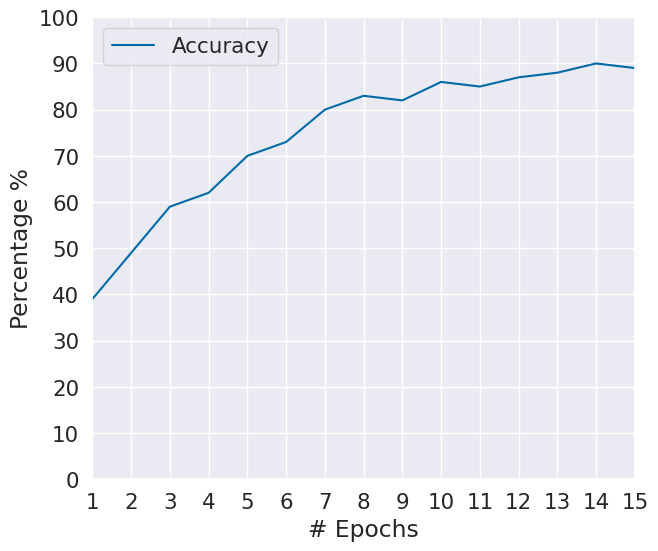

In [ ]:
# 绘制训练过程中准确率的变化曲线
plt.figure(figsize=(7,6))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,1,1)
plt.plot(np.linspace(1,15,15), epochs_score, label="Accuracy")
plt.xticks([i for i in range(1,16,1)])
plt.yticks([i for i in range(0,110,10)])
ax = plt.gca()
ax.set_xlim([1,15])
ax.set_ylim([0,100])
plt.xlabel("# Epochs")
plt.ylabel("Percentage %")
ax.grid(True, which='major', color='#FFFFFF', linestyle='-')
plt.legend()

plt.show()

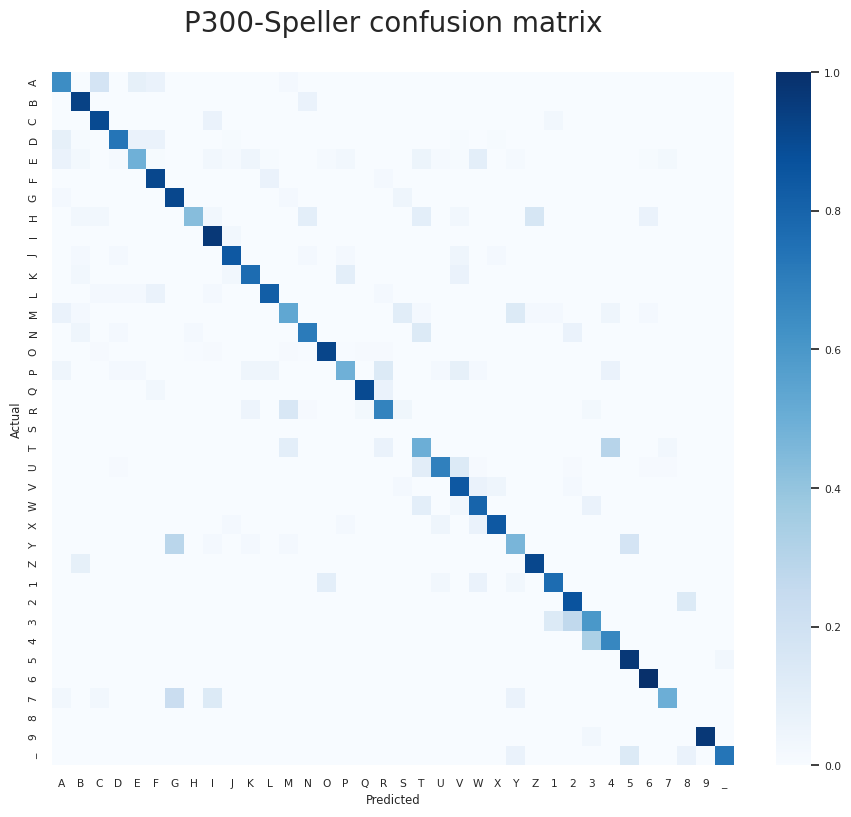

In [ ]:
# 用于创建样本权重向量、计算混淆矩阵，并绘制归一化的混淆矩阵热图
# Create sample weights vector
s_dict = {}
s_weights = []
for word in word_test[0]:
    if word not in s_dict.keys():
        s_dict[word] = 1
    else:
        s_dict[word] += 1
for word in word_test[0]:
    s_weights.append(len(word_test[0])/s_dict[word])

# Confusion matrix (36 classes)
labels = list(s) # s = Uppercase letters + numbers [1->9] + _
confusion_epoch = np.zeros((36, 36))
for i in range(1, 15 + 1):
    spelldata = confusion_matrix(y_true=list(word_test[0]), y_pred=speller_pred[i], sample_weight=s_weights, labels=labels)
    # Normalized confusion matrix (values in range 0-1)
    spelldata_norm = spelldata/np.full(spelldata.shape, len(word_test[0]))
    # Add the confusion matrix of all epoch together
    confusion_epoch += spelldata_norm/15

# Plot the confusion matrix
df_cm = pd.DataFrame(confusion_epoch, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (11,9))
sns.set(font_scale = 0.7)
cm = sns.heatmap(df_cm, cmap="Blues", vmin=0, vmax=1)
cm.axes.set_title("P300-Speller confusion matrix\n", fontsize=20)
plt.show()